In [3]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
from matplotlib.ticker import FormatStrFormatter

import glob
import os
from scipy.io import FortranFile
class Multifile:
    '''reads the simulated lattice images
 
    '''
    from scipy.io import FortranFile
    import os
    import shutil,glob

    def __init__(self,filepath, filename, lattice_size, qz_prime):
        '''here, it prepares to read the lattice image. Reading happens, and scattering image is shown when .rdframe() is called
        filename is letters after 000 format. 
        '''
        self.filepath = filepath
        self.filename = filename
        self.lattice_size = lattice_size
        self.qz_prime = qz_prime
        

    
    def rdframe(self,n):
        #first read the data 
        frame = "{0:0=4d}".format(n) + self.filename
        f = FortranFile(self.filepath + frame, 'r' )
        image = f.read_reals( dtype='float32' )
        image_mod = image.reshape((lattice_size,lattice_size),order='F')
        
        #trim the border pixel if we have 1026 or 2050. They are ghost cells. Here I am assuming we don't go over 2048x2048
        if lattice_size == 1026:
            image_mod = image_mod[1:-1,1:-1]
        elif lattice_size ==  2050:
            image_mod = image_mod[1:-1,1:-1]
        
        image_mod = np.rot90(image_mod) #so that the image is rotated 90 degree counter clock-wise

        #Fourier transform and then do the absolute square
        fftimage= np.fft.fft2(np.exp(-1j *self.qz_prime*image_mod),axes=(0, 1)) #   image_mod  np.exp(-1j *self.qz_prime*image_mod)
        gixaxs = fftimage * np.conj(fftimage)
        gixaxs = gixaxs/((self.qz_prime)**2)/(self.lattice_size)**2 #normalized by area
        
        gixaxs= np.fft.fftshift(gixaxs)# move frequency zero to center

        scattering = np.real(gixaxs[:,:]) # may do lattice_size//2 limit if you desire. will have lattice_size x lattice_size 
        half_pt = self.lattice_size//2
        scattering[half_pt,half_pt] = np.average(scattering[half_pt-2:half_pt+3:3,half_pt-2:half_pt+3:3]) # skip the center point! it will affect average
        return(scattering)
    
    def rdlattice(self,n):
        #first read the data 
        frame = "{0:0=4d}".format(n) + self.filename
        f = FortranFile(self.filepath + frame, 'r' )
        image = f.read_reals( dtype='float32' )
        image_mod = image.reshape((lattice_size,lattice_size),order='F')
        
        #trim the border pixel if we have 1026 or 2050. They are ghost cells. Here I am assuming we don't go over 2048x2048
        if lattice_size == 1026:
            image_mod = image_mod[1:-1,1:-1]
        elif lattice_size ==  2050:
            image_mod = image_mod[1:-1,1:-1]
        image_mod = np.rot90(image_mod) #so that the image is rotated 90 degree counter clock-wise    
        return(image_mod)

#rewrite pixel to q conversion
def convert_pixel_to_q(x,y):
    x,y=np.int(x),np.int(y)
    """for complex Fourier Transform images, we know the conversion already."""
    q_range = np.linspace(-(lattice_size//2)*((2*np.pi)/(lattice_size*latticeUnit_to_nm)), (lattice_size//2)*((2*np.pi)/(lattice_size*latticeUnit_to_nm)), num=lattice_size +1)
    
    q_x,q_y,q_z,q,alpha_f,qx_prime,qy_prime,qz_prime = 0,q_range[x],q_range[y],(q_range[x]**2+q_range[x]**2)**(0.5),0,0,q_range[x],q_range[y]
    
    return(q_x,q_y,q_z,q,alpha_f,qx_prime,qy_prime,qz_prime) 

#plot lattaice image
'''
The following functions work after loading the class
'''
def plot_lattice_image(frames=[], slice = False, x = [], y = [], swap_xy_cross_section = False, save = 0, name = 'test'):
    image = FD.rdlattice(frames[0])
    for i in frames[1:]: # average over given frames
        image += FD.rdlattice(i)
    image = image/len(frames)
    fig, ax = plt.subplots(figsize=(7,7))
    dimension = np.shape(image)[0]
    rms = np.sqrt(np.mean(image**2))
    std = np.std(image)
    ax = plt.gca()
    print(np.shape(image))
    
    
    im = ax.imshow(image-rms, vmin = rms-4*std-rms, vmax = rms+3*std-rms, origin = 'lower', extent = [0,latticeUnit_to_nm*dimension,0,latticeUnit_to_nm*dimension], interpolation = 'none')#cmap=cmap_albula) 
    ax.set_ylabel(r'$L$ [nm]')
    ax.set_xlabel(r'$L$ [nm]')
    
    
    #plot inset
    if slice == True:
        # These are in unitless percentages of the figure size. (0,0 is bottom left)
        left, bottom, width, height = [0.34, 0.25, 0.50, 0.25]
        ax2 = fig.add_axes([left, bottom, width, height])
        ax2.set_title('Cross Section')
        dimension = np.shape(image)[0]
    #     if logscale:
    #         scattering = np.log(scattering)
        rms = np.sqrt(np.mean(image**2))
        std = np.std(image)

        img = image[0:dimension,0:dimension] ####
        if swap_xy_cross_section == True:
            img = np.rot90(img)

        if isinstance(y,list):
            slice_avg = np.average(img[y[0]:y[1],x[0]:x[1]], axis = 0)
            y_avg = y[0]
        else:
            slice_avg = img[y,x[0]:x[1]]
            y_avg = y
        x_pixels = np.arange(x[0],x[1])
        L_vals = x_pixels
        ax2.plot(L_vals,slice_avg-rms)
        # plt.title(r'$q_z$ = ' + np.str_(np.round(convert_pixel_to_q(0,y_avg)[2],decimals=2)) + r' $nm^{-1}$')
        ax2.set_ylabel('Height [nm]')
        ax2.set_xlabel('L [nm]')
        ax2.set_title('Cross Section along X')
        if swap_xy_cross_section == True:
            ax2.set_title('Cross Section along Y')
        ####
        ax2.set_ylim(rms-4*std-rms,rms+3*std-rms)
        ax2.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    
    
    # create an axes on the right side of ax. The width of cax will be 5%
    # of ax and the padding between cax and ax will be fixed at 0.05 inch.
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax, format='%.2f')
    if save == 1:
        ax.set_title('Lattice image')
        plt.suptitle('A (c0x) = {0}'.format(metadata[0]) +
                     r', $\nu_y$ (c1x) = {0}'.format(metadata[1]) +
                     r', $\nu_x$ (c1y) = {0}'.format(metadata[2]) +
                     ', ' + r'$\kappa$ (c4) = {0}'.format(metadata[3]) + 
                     r', $\lambda_x$ (c2x) = {0}'.format(metadata[4])+
                     r', $\lambda_y$ (c2y) = {0}'.format(metadata[5])+
                     ', \n ' + r'$\gamma_y$ (c3x) = {0}'.format(metadata[6]) +
                     r', $\eta$ (c3) = {0}'.format(metadata[7]) +
                     r', $\Delta$t (delt) = {0}'.format(metadata[8])+
                     ', niter = {0}'.format(metadata[9])+
                     ', nsteps = {0}'.format(number_of_images)+
                     ', seed = {0}'.format(metadata[10]), fontsize=10)
    if save == 1:
        plt.savefig(name+'.png',bbox_inches='tight', dpi= 300)
    plt.show()
    print('RMS of lattice image is ',np.sqrt(np.mean(image**2)))

def slice_lattice_img(x,y,frames=[0]):
    img = FD.rdlattice(frames[0])
    for i in frames[1:]:
        img += FD.rdlattice(i)
    img = img/len(frames)
    dimension = np.shape(img)[0]
#     if logscale:
#         scattering = np.log(scattering)
    rms = np.sqrt(np.mean(img**2))
    
    img = img[0:dimension,0:dimension] ####
    
    if isinstance(y,list):
        slice_avg = np.average(img[y[0]:y[1],x[0]:x[1]], axis = 0)
        y_avg = y[0]
    else:
        slice_avg = img[y,x[0]:x[1]]
        y_avg = y
    x_pixels = np.arange(x[0],x[1])
    L_vals = x_pixels
    
    
    plt.figure(figsize= (7.2*1.5,4.45*1.5))
    plt.plot(L_vals,slice_avg)
    # plt.title(r'$q_z$ = ' + np.str_(np.round(convert_pixel_to_q(0,y_avg)[2],decimals=2)) + r' $nm^{-1}$')
    plt.ylabel('Height [nm]')
    plt.xlabel('L [nm]')
    plt.suptitle('A (c0x) = {0}'.format(metadata[0]) +
                 r', $\nu_y$ (c1x) = {0}'.format(metadata[1]) +
                 r', $\nu_x$ (c1y) = {0}'.format(metadata[2]) +
                 ', ' + r'$\kappa$ (c4) = {0}'.format(metadata[3]) + 
                 r', $\lambda_x$ (c2x) = {0}'.format(metadata[4])+
                 r', $\lambda_y$ (c2y) = {0}'.format(metadata[5])+
                 ', \n ' + r'$\gamma_y$ (c3x) = {0}'.format(metadata[6]) +
                 r', $\eta$ (c3) = {0}'.format(metadata[7]) +
                 r', $\Delta$t (delt) = {0}'.format(metadata[8])+
                 ', niter = {0}'.format(metadata[9])+
                 ', nsteps = {0}'.format(number_of_images)+
                 ', seed = {0}'.format(metadata[10]), fontsize=10)
    # plt.legend(loc='best')

    plt.show()

#plot scattering pattern
def plot_scattering_image(frames=[], logscale = False, pixels= False,slice_pt=[0,0,0,0]): ####
    scattering = FD.rdframe(frames[0])
    
    #determine extent
    y1,y2,x1,x2 = -(lattice_size//2),(lattice_size//2),-(lattice_size//2),(lattice_size//2)
    for i in frames[1:]:
        scattering += FD.rdframe(i)
    scattering = scattering/len(frames)    
    if slice_pt!=[0,0,0,0]:
        scattering = scattering[slice_pt[0]:slice_pt[1],slice_pt[2]:slice_pt[3]]
        y1,y2,x1,x2 = -(lattice_size//2-slice_pt[0]),(slice_pt[1]-lattice_size//2), -(lattice_size//2-slice_pt[2]),(slice_pt[3]-lattice_size//2)

    plt.figure(figsize=(7,7)) #figsize=(10*((slice_pt[1]-slice_pt[0])/lattice_size),10*((slice_pt[3]-slice_pt[2])/lattice_size)))
    print(np.shape(scattering))
    
#     dimension = np.shape(scattering)[0]


#     if logscale:
#         scattering = np.log(scattering)
    rms = np.sqrt(np.average(scattering)**2)
    avg_img = np.average(scattering)
    maxval = np.amax(scattering)
    
#     scattering = scattering[0:dimension,0:dimension] ####
    
    ax = plt.gca()
    if logscale:
        if pixels:
            im = ax.imshow(scattering, origin = 'lower', interpolation = 'none',norm=LogNorm(vmin=0.01, vmax=maxval))#cmap=cmap_albula) 
        else:
            im = ax.imshow(scattering, origin = 'lower', \
                           extent = [y1*((2*np.pi)/(lattice_size*latticeUnit_to_nm)),\
                                     y2*((2*np.pi)/(lattice_size*latticeUnit_to_nm)),\
                                     x1*((2*np.pi)/(lattice_size*latticeUnit_to_nm)),\
                                     x2*((2*np.pi)/(lattice_size*latticeUnit_to_nm))],\
                           interpolation = 'none',norm=LogNorm(vmin=0.01, vmax=maxval))#cmap=cmap_albula) 
    else:
        if pixels:
            im = ax.imshow(scattering, vmin = 0.01 , vmax = maxval, origin = 'lower')#cmap=cmap_albula) 
        else:
            im = ax.imshow(scattering, vmin = 0.01 , vmax = maxval, origin = 'lower', \
                           extent = [y1*((2*np.pi)/(lattice_size*latticeUnit_to_nm)),\
                                     y2*((2*np.pi)/(lattice_size*latticeUnit_to_nm)),\
                                     x1*((2*np.pi)/(lattice_size*latticeUnit_to_nm)),\
                                     x2*((2*np.pi)/(lattice_size*latticeUnit_to_nm))],\
                           interpolation = 'none',norm=LogNorm(vmin=0.01, vmax=maxval))#cmap=cmap_albula) 

    ax.set_ylabel(r'$q_y$ $[nm^{-1}]$')
    ax.set_xlabel(r'$q_x$ $[nm^{-1}]$')
    # create an axes on the right side of ax. The width of cax will be 5%
    # of ax and the padding between cax and ax will be fixed at 0.05 inch.
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)
    ax.set_title('Scattering image')
    plt.suptitle('A (c0x) = {0}'.format(metadata[0]) +
                 r', $\nu_y$ (c1x) = {0}'.format(metadata[1]) +
                 r', $\nu_x$ (c1y) = {0}'.format(metadata[2]) +
                 ', ' + r'$\kappa$ (c4) = {0}'.format(metadata[3]) + 
                 r', $\lambda_x$ (c2x) = {0}'.format(metadata[4])+
                 r', $\lambda_y$ (c2y) = {0}'.format(metadata[5])+
                 ', \n ' + r'$\gamma_y$ (c3x) = {0}'.format(metadata[6]) +
                 r', $\eta$ (c3) = {0}'.format(metadata[7]) +
                 r', $\Delta$t (delt) = {0}'.format(metadata[8])+
                 ', niter = {0}'.format(metadata[9])+
                 ', nsteps = {0}'.format(number_of_images)+
                 ', seed = {0}'.format(metadata[10]), fontsize=10)
#     if slice_pt!=[0,0,0,0]:
#         plt.gca().axis([slice_pt[0],slice_pt[1],slice_pt[2],slice_pt[3]])
    plt.show()
    print('RMS of scattering image is ',rms)
    print('Max of scattering image is ',np.amax(scattering))
    print('Avg of scattering image is ',np.average(scattering))
    
def slice_scat_img(x,y,frames=[0], fold=False):
    scattering = FD.rdframe(frames[0])
    
    for i in frames[1:]:
        scattering += FD.rdframe(i)
    scattering = scattering/len(frames)
#     dimension = np.shape(scattering)[0]
#     if logscale:
#         scattering = np.log(scattering)
#     rms = np.sqrt(np.mean(scattering)**2)
    
#     scattering = scattering[0:dimension,0:dimension] ####
    
    if isinstance(y,list):
        slice_avg = np.average(scattering[y[0]:y[1],x[0]:x[1]], axis = 0)
        y_avg = y[0]
    else:
        slice_avg = scattering[y,x[0]:x[1]]
        y_avg = y
    x_pixels = np.arange(x[0],x[1])
    qvals = []
    rms = np.sqrt(np.mean(slice_avg)**2) # [:len(slice_avg)//2-4]
    maxval = np.amax(slice_avg)
    print(rms)
    for i in range(len(x_pixels)):
        qvals.append(convert_pixel_to_q(x_pixels[i],y_avg)[1])  
    qvals = np.asarray(qvals)
    
    if fold == True:
        size = len(slice_avg)
        slice_avg1 = slice_avg[size//2:]
        qvals1 = qvals[size//2:]
        
        slice_avg2 = slice_avg[:size//2]
        qvals2 = qvals[:size//2]*(-1)
    
    plt.figure(figsize= (7.2,4.45))
    if fold == True:
        plt.scatter(qvals1,slice_avg1, label='right')
        plt.scatter(qvals2,slice_avg2, label='left')
    else:    
        plt.scatter(qvals,slice_avg)
    # plt.title(r'$q_z$ = ' + np.str_(np.round(convert_pixel_to_q(0,y_avg)[2],decimals=2)) + r' $nm^{-1}$')
    plt.ylabel('Intensity [A.U.]')
    plt.xlabel(r'$q_{//}$ [$nm^{-1}$]')
    # plt.legend(loc='best')
    if fold == True:
        plt.xlim(qvals1[0],qvals1[-1])
    else:
        plt.xlim(qvals[0],qvals[-1])
    if True:
        plt.yscale('log')
        plt.gca().set_ylim(0.01, 2*maxval)
    plt.suptitle('A (c0x) = {0}'.format(metadata[0]) +
                 r', $\nu_y$ (c1x) = {0}'.format(metadata[1]) +
                 r', $\nu_x$ (c1y) = {0}'.format(metadata[2]) +
                 ', ' + r'$\kappa$ (c4) = {0}'.format(metadata[3]) + 
                 r', $\lambda_x$ (c2x) = {0}'.format(metadata[4])+
                 r', $\lambda_y$ (c2y) = {0}'.format(metadata[5])+
                 ', \n ' + r'$\gamma_y$ (c3x) = {0}'.format(metadata[6]) +
                 r', $\eta$ (c3) = {0}'.format(metadata[7]) +
                 r', $\Delta$t (delt) = {0}'.format(metadata[8])+
                 ', niter = {0}'.format(metadata[9])+
                 ', nsteps = {0}'.format(number_of_images)+
                 ', seed = {0}'.format(metadata[10]), fontsize=10)
    plt.legend(loc='best')
    plt.show()

Looking at the folder batch_p1024_n0p26_n0p45_0p45_6p96_1p94_1p94_11p89_0p1_0p001_2000_764083427
Number if images: 999
Metadata: ['-0.26', '-0.45', '0.45', '6.96', '1.94', '1.94', '11.89', '0.1', '0.001', '2000', '764083427']
(1024, 1024)


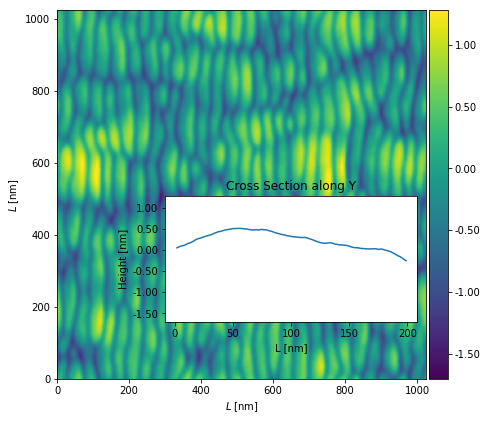

RMS of lattice image is  1.9614851
(1024, 1024)


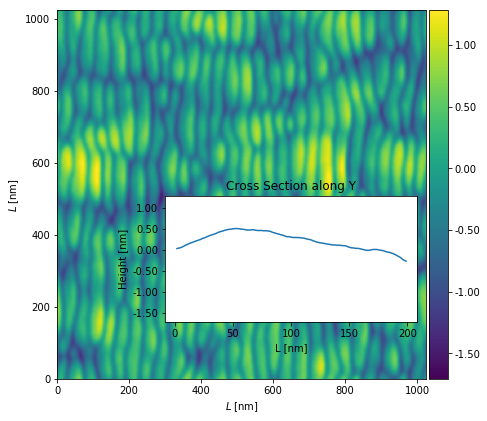

RMS of lattice image is  1.9681807
(1024, 1024)


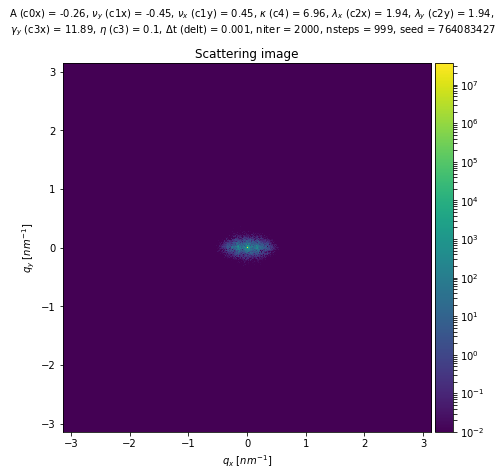

RMS of scattering image is  34.13509849157802
Max of scattering image is  35604524.00761487
Avg of scattering image is  34.13509849157802


In [4]:

#### load images
# filepath = '/home/pmyint/SIMULATIONS/batch_kslat_lamshin/1024_n0p26_0p45_n0p45_6p96_1p94_1p94_11p89_0p1_0p001_2000_25474675/'
filepath = '/home/pmyint/analysis/2019_2/pmyint/SIMULATIONS/newJosh/batch_p1024_n0p26_0p45_n0p45_6p96_3p88_3p88_11p89_0p1_0p001_2000_693538395/'
filepath = '/Users/pecomyint/Downloads/batch_p1024_n0p26_n0p45_0p45_6p96_1p94_1p94_11p89_0p1_0p001_2000_764083427/'
foldername = filepath.split('/')[-2]
print('Looking at the folder {0}'.format(foldername))


lattice_size = 1026
datatakingtime = 2 #divide time unit by number of frames
latticeUnit_to_nm = 1 # because it is one, spline fit is not necessary 
qz_prime = 0.17082401254653182 
FD = Multifile(filepath, '_1024_n0p26_n0p45_0p4', lattice_size,qz_prime)
number_of_images = len(glob.glob(filepath+'*'))
print('Number if images: {0}'.format(number_of_images))

#metadata 
metadata_text = foldername
metadata_text = metadata_text.replace('_',' ').replace('n','-').replace('p','.')
metadata = metadata_text.split(' ')[2:]
print('Metadata: {0}'.format(metadata))


# md['eiger4m_single_cam_num_images'] = number_of_images
uid = foldername
# mask = np.ones((lattice_size//2,lattice_size//2))


#### Plot lattice images and scattering image
plot_lattice_image(frames=[603],slice = True, x = [2,200], y = [502,503], swap_xy_cross_section = True, save = 0)
plot_lattice_image(frames=[604],slice = True, x = [2,200], y = [502,503], swap_xy_cross_section = True, save = 0)
plot_scattering_image(frames=[602])

In [5]:
################################
######Movie_maker###############
################################ 


def read_imgs( inDir ):
    '''Give image folder: inDir
    Get a pims.sequences,
    e.g. inDir= '/home/.../*.png'
    '''
    from pims import ImageSequence as Images
    return Images( inDir  )

 


def select_regoin(img, vert, keep_shape=True, qmask=None,  ):
    '''Get a pixellist by a rectangular region
        defined by
        verts e.g. xs,xe,ys,ye = vert #x_start, x_end, y_start,y_end
        (dimy, dimx,) = img.shape
       Giving cut postion, start, end, width '''
    import numpy as np

    xs,xe,ys,ye = vert
    if keep_shape:       
        img_= np.zeros_like( img )
        #img_= np.zeros( [dimy,dimx])
    
        try:
            img_[ys:ye, xs:xe] = True
        except:
            img_[ys:ye, xs:xe,:] = True
        pixellist_ = np.where( img_.ravel() )[0]
        #pixellist_ =  img_.ravel()
        if qmask is not None:
            b=np.where(  qmask.flatten()==False )[0]
            pixellist_ = np.intersect1d(pixellist_,b)
        #imgx = img[pixellist_]
        #imgx = imgx.reshape( xe-xs, ye-ys)
        imgx = img_.ravel()    
        imgx[pixellist_] = img.ravel()[pixellist_]   
        imgx = imgx.reshape(  img.shape )
        
    else:         
        try:
            imgx =img[ys:ye, xs:xe]
        except:
    
            imgx =img[ys:ye, xs:xe,:]
        
    return  imgx
 
def save_png_series( imgs, ROI=None, logs=True, outDir=None, uid=None,vmin=None, vmax=None,cmap='viridis',dpi=100):
    import numpy as np
    import matplotlib.pyplot as plt
    from matplotlib.colors import LogNorm

    """
    save a series of images in a format of png
    
    Parameters
    ----------
    imgs : array
        image data array for the movie
        dimensions are: [num_img][num_rows][num_cols]
    ROI: e.g. xs,xe,ys,ye = vert #x_start, x_end, y_start,y_end
    outDir: the output path
    vmin/vmax: for image contrast
    cmap: the color for plot
    dpi: resolution 
    Returns
    -------
    save png files 
    """     
    if uid==None:
        uid='uid'
    num_frame=0
    for img in imgs: 
        fig = plt.figure()
        ax = fig.add_subplot(111)  
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if ROI is None:
            i0=img
            asp =1.0         
        else:
            i0=select_regoin(img, ROI, keep_shape=False,)
            xs,xe,ys,ye = ROI        
            asp = (ye-ys)/float( xe - xs ) 
        ax.set_aspect('equal')  
        
        if not logs:         
            im=ax.imshow(i0, origin='lower' ,cmap=cmap,interpolation="nearest", vmin=vmin,vmax=vmax)  #vmin=0,vmax=1,
        else:
            im=ax.imshow(i0, origin='lower' ,cmap=cmap,
                        interpolation="nearest" , norm=LogNorm(vmin,  vmax)) 
        #ttl = ax.text(.75, .2, '', transform = ax.transAxes, va='center', color='white', fontsize=18) 
        #fig.set_size_inches( [5., 5 * asp] )
        #plt.tight_layout()  
        fname = outDir + 'uid_%s-frame-%s.png'%(uid,num_frame )
        num_frame +=1
        plt.savefig( fname, dpi=None )
    
    

    
def movie_maker( imgs, num_frames=None, ROI=None,interval=20, fps=15, real_interval = 1.0, movie_name="movie.mp4", outDir=None, movie_writer='ffmpeg', logs=True, show_text_on_image=False, vmin=None, vmax=None,cmap='viridis',dpi=100):
    
    import numpy as np
    import matplotlib.pyplot as plt
    import matplotlib.animation as animation
    from matplotlib.colors import LogNorm

    """
    Make a movie by give a image series
    
    Parameters
    ----------
    imgs : array
        image data array for the movie
        dimensions are: [num_img][num_rows][num_cols]
    ROI: e.g. xs,xe,ys,ye = vert #x_start, x_end, y_start,y_end
    num_frames : int
        number of frames in the array
    interval : int, optional
        delay between frames
    movie_name : str, optional
        name of the movie to save
    movie_writer : str, optional
        movie writer
    fps : int, optional
        Frame rate for movie.
    
    real_interval:
       the real time interval between each frame in unit of ms
    outDir: the output path
    vmin/vmax: for image contrast
    cmap: the color for plot
    dpi: resolution       
    Returns
    -------
    #ani :
    #    movie
    """    
     
    fig = plt.figure(figsize=(20,20))
    ax = fig.add_subplot(111)    
    
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    if ROI is None:
        i0=imgs[0]
        asp =1.0 
        
    else:
        i0=select_regoin(imgs[0], ROI, keep_shape=False,)
        xs,xe,ys,ye = ROI        
        asp = (ye-ys)/float( xe - xs )      
         
    ax.set_aspect('equal') 
    #print( cmap, vmin, vmax )
    
    if not logs:         
        im=ax.imshow(i0, origin='upper' ,cmap=cmap,interpolation="nearest", vmin=vmin,vmax=vmax)  
    else:
        im=ax.imshow(i0, origin='upper' ,cmap=cmap,
                        interpolation="nearest" , norm=LogNorm(vmin,  vmax))     

    #ttl = ax.text(.75, .2, '', transform = ax.transAxes, va='center', color='white', fontsize=18)
    ttl = ax.text(.75, .2, '', transform = ax.transAxes, va='center', color='black', fontsize=18)
    #print asp
    #fig.set_size_inches( [5., 5 * asp] )
 
    
    plt.tight_layout()
    
    if num_frames is None:num_frames=len(imgs)
    def update_img(n):
        if ROI is None:ign=imgs[n]
        else:ign=select_regoin(imgs[n], ROI, keep_shape=False,)
        im.set_data(ign)
        if show_text_on_image:
            if real_interval >=10:
                ttl.set_text('%s s'%(n*real_interval/1000.))  
            elif real_interval <10:
                ttl.set_text('%s ms'%(n*real_interval))         
            #im.set_text(n)
            #print (n)

    ani = animation.FuncAnimation(fig, update_img, num_frames,
                                  interval=interval)
    writer = animation.writers[movie_writer](fps=fps)

    if outDir is not None:movie_name = outDir + movie_name
    ani.save(movie_name, writer=writer,dpi=dpi)
    #return ani

In [6]:
pwd

'/Users/pecomyint/Desktop'

In [7]:
uid

'batch_p1024_n0p26_n0p45_0p45_6p96_1p94_1p94_11p89_0p1_0p001_2000_764083427'

In [8]:
metadata

['-0.26',
 '-0.45',
 '0.45',
 '6.96',
 '1.94',
 '1.94',
 '11.89',
 '0.1',
 '0.001',
 '2000',
 '764083427']

/Users/pecomyint/anaconda3/lib/python3.6/site-packages/pims/image_sequence.py:152: UserWarning: Loading ALL files in this directory. To ignore extraneous files, use a pattern like 'path/to/images/*.png'
  UserWarning)


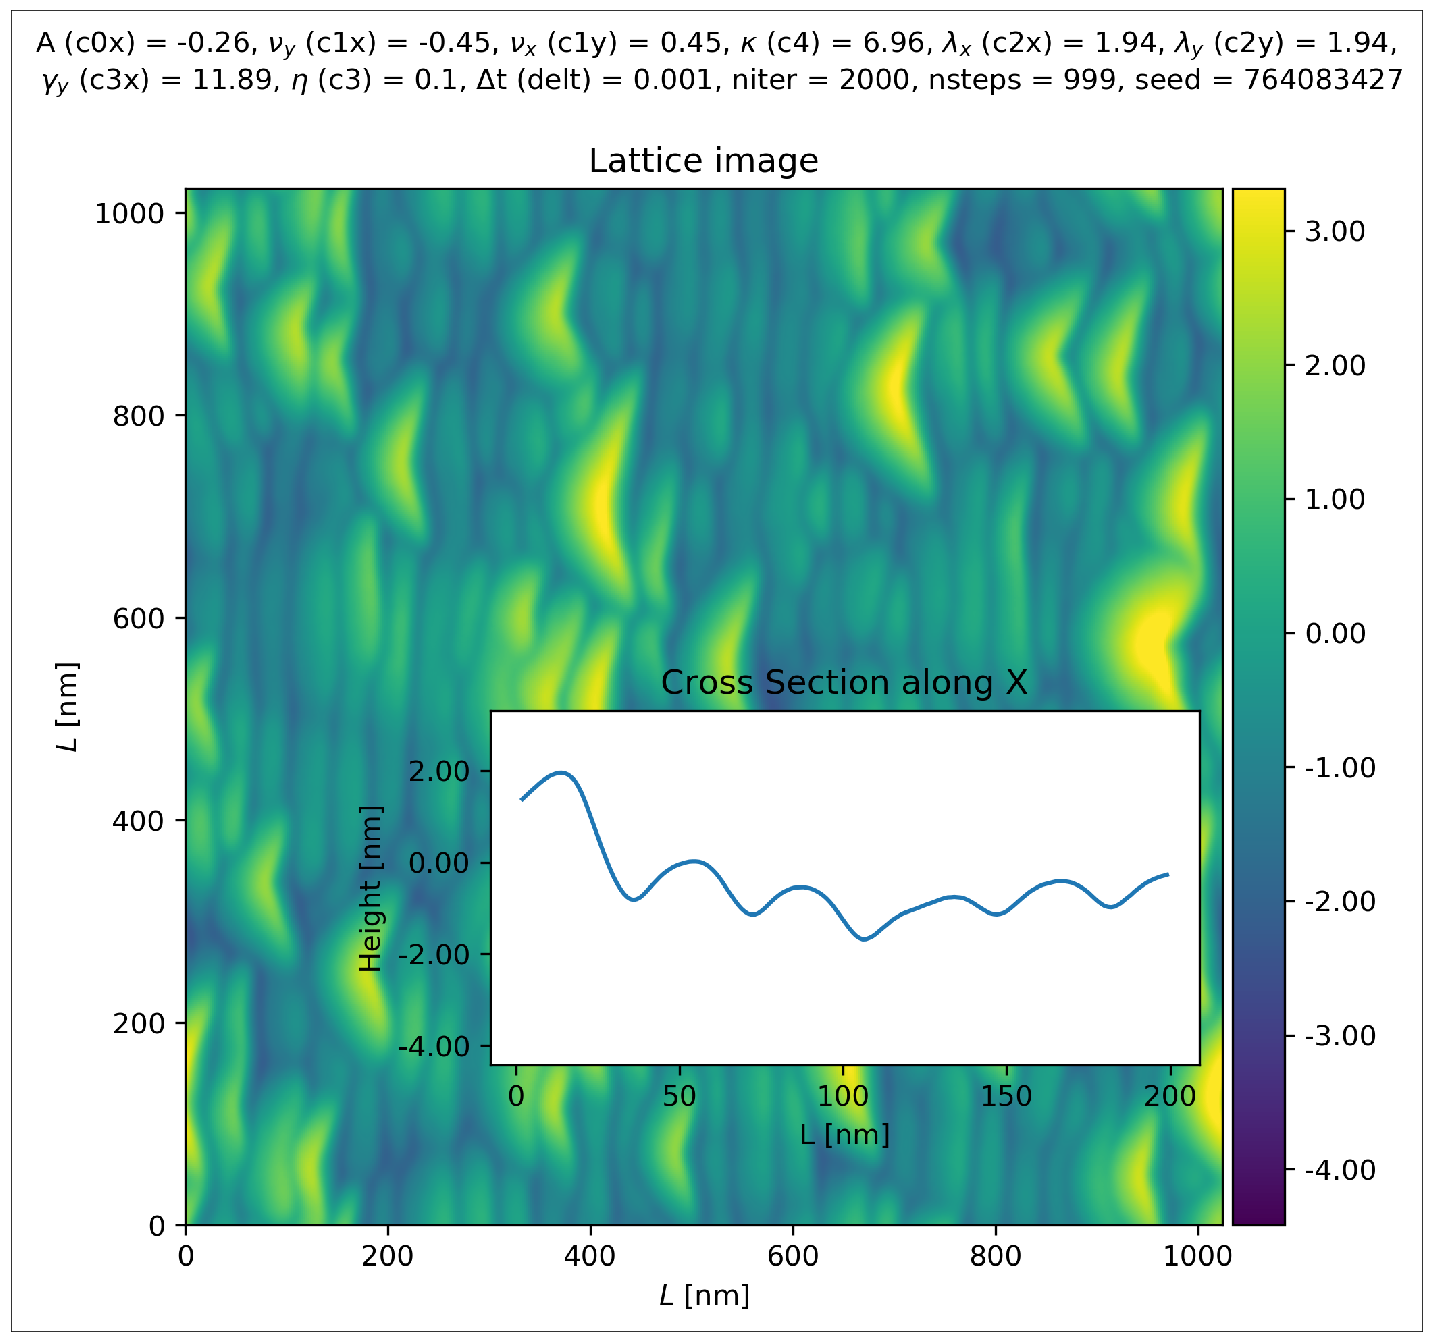

In [9]:
uid = 'Xslice_Video_1024_n0p26_n0p45_0p45_6p96_1p94_1p94_11p89_0p1_0p001_2000_764083427'
from tqdm import tqdm
fps= 15#round(DD.DD['numberfiles']/8)
movielength = 20
p = 1
alpha=0.5
vmin=0.01
vmax=30.
start = 1
stop = 999
# for i in tqdm(np.arange(start,stop,round(stop/(fps*movielength)))):
    
#     directory_exists = os.path.isdir('/Users/pecomyint/Desktop/' + '%s_'%(uid) +'/')
#     if directory_exists == False:
#         os.makedirs('/Users/pecomyint/Desktop/' + '%s_'%(uid) +'/')
#     os.chdir('/Users/pecomyint/Desktop/' + '%s_'%(uid) +'/')
#     plot_lattice_image([i],slice = True, x = [2,200], y = [502,503], swap_xy_cross_section = False, save = 1, name = np.str(p))
#     p += 1
fps_movie = fps
movie_maker(read_imgs('/Users/pecomyint/Desktop/' + '%s_'%(uid)), num_frames=None, ROI=None,interval=20, fps=fps_movie, real_interval = 1.0, movie_name='%s_'%(uid) +'_all' + '.mp4', outDir=None,movie_writer='ffmpeg', logs=True, show_text_on_image=False,vmin=None, vmax=None,cmap='viridis',dpi=150)



  0%|          | 0/333 [00:00<?, ?it/s]

(1024, 1024)


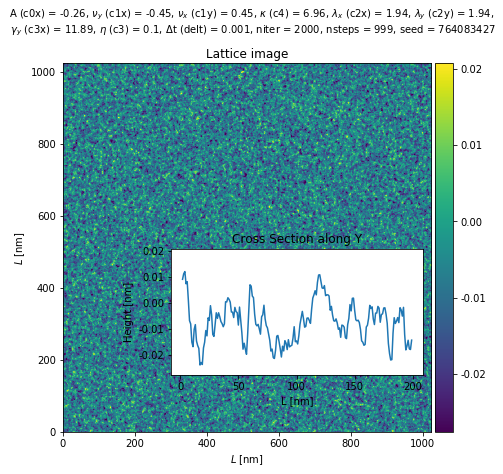

  0%|          | 1/333 [00:03<22:00,  3.98s/it]

RMS of lattice image is  0.006912448
(1024, 1024)


In [ ]:
uid = 'Yslice_Video_1024_n0p26_n0p45_0p45_6p96_1p94_1p94_11p89_0p1_0p001_2000_764083427'
from tqdm import tqdm
fps= 15#round(DD.DD['numberfiles']/8)
movielength = 20
p = 1
alpha=0.5
vmin=0.01
vmax=30.
start = 1
stop = 999
# for i in tqdm(np.arange(start,stop,round(stop/(fps*movielength)))):
    
#     directory_exists = os.path.isdir('/Users/pecomyint/Desktop/' + '%s_'%(uid) +'/')
#     if directory_exists == False:
#         os.makedirs('/Users/pecomyint/Desktop/' + '%s_'%(uid) +'/')
#     os.chdir('/Users/pecomyint/Desktop/' + '%s_'%(uid) +'/')
#     plot_lattice_image([i],slice = True, x = [2,200], y = [502,503], swap_xy_cross_section = True, save = 1, name = np.str(p))
#     p += 1
fps_movie = fps
movie_maker(read_imgs('/Users/pecomyint/Desktop/' + '%s_'%(uid)), num_frames=None, ROI=None,interval=20, fps=fps_movie, real_interval = 1.0, movie_name='%s_'%(uid) +'_all' + '.mp4', outDir=None,movie_writer='ffmpeg', logs=True, show_text_on_image=False,vmin=None, vmax=None,cmap='viridis',dpi=150)

